In [1]:
import sys
sys.path.append("../")
from utils.datasets import Datasets
from utils.save_results import save_info, plot_graph, plot_scatter, plot_histogram
from utils.utils import dict_to_PCA, dict_to_oneVSothers

from utils.classifier_centerdiscriminant import ClassifierCenterDiscriminant
from utils.adaptive_centerloss import AdaptiveCenterLoss
from utils.adaptive_discriminantloss import AdaptiveDiscriminantLoss
from utils.networks import Net

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

f:\university\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1

# cuda or cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Dataset config
DATASET = 'MNIST'
DATASET_DIR = './dataset'
BATCH_SIZE = 100
NUM_WORKERS = 2

# Optimizer config
WEIGHT_DECAY = 0.001
LEARNING_RATE = 0.01
GAMMA = 0.1
STEPS = 50

# Training config
EPOCH = 100

# Center/Discriminatn Loss config
DIM = 128
center_ALPHA = 0.9
discriminant_ALPHA = 0.9
center_LAMBDA = 0.1
discriminant_LAMBDA = 0.01

In [3]:
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_trans = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
test_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
instance_datasets = Datasets(
    DATASET,
    BATCH_SIZE,
    NUM_WORKERS,
    transform=train_trans,
    test_transform=test_trans,
    dataset_dir=DATASET_DIR,
)
data_sets = instance_datasets.create()

trainloader = data_sets[0]
testloader = data_sets[1]
classes = data_sets[2]
based_labels = data_sets[3]
input_channels = data_sets[4]
trainset = data_sets[5]
testset = data_sets[6]

Dataset : MNIST
set train data
set test data


In [5]:
model = Net(
    input_channels=input_channels,
    num_classes=len(classes),
    dim=DIM,
).to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEPS,
    gamma=GAMMA,
)

criterion = nn.CrossEntropyLoss()
centerloss = AdaptiveCenterLoss(
    len(classes),
    DIM,
    center_ALPHA,
)
discriminantloss = AdaptiveDiscriminantLoss(
    len(classes),
    discriminant_ALPHA,
)

cfcd = ClassifierCenterDiscriminant(
    model,
    optimizer,
    criterion,
    centerloss,
    discriminantloss,
    center_LAMBDA,
    discriminant_LAMBDA,
)

In [6]:
losses, cel_losses, center_losses, discriminant_losses, accuracies = cfcd.fit(
    EPOCH,
    trainloader,
    testloader,
    scheduler=scheduler,
    device=device,
)

epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:25<00:00, 23.74it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 51.26it/s]


mean_loss=0.21336358131219943, mean_cel_loss=0.12901239963248373,mean_center_loss=0.17182396156092486, mean_discriminant_loss=6.716878699461619,acc=0.9615666666666667
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.99it/s]


mean_loss=0.20795778200030327, mean_cel_loss=0.1250118465255946,mean_center_loss=0.16822626188397408, mean_discriminant_loss=6.612331013679505,acc=0.9633
epoch:2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:25<00:00, 23.47it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 54.01it/s]


mean_loss=0.13789829899867376, mean_cel_loss=0.06894039978894094,mean_center_loss=0.11438604024549326, mean_discriminant_loss=5.751929649511973,acc=0.97965
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.16it/s]


mean_loss=0.1347382777184248, mean_cel_loss=0.06715186045505106,mean_center_loss=0.11314555592834949, mean_discriminant_loss=5.6271863317489625,acc=0.9798
epoch:3


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:25<00:00, 23.50it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 52.81it/s]


mean_loss=0.11569105500976244, mean_cel_loss=0.057091412940062584,mean_center_loss=0.0932960938786467, mean_discriminant_loss=4.927003371318182,acc=0.9835333333333334
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.47it/s]

mean_loss=0.11297575693577527, mean_cel_loss=0.05606771910795942,mean_center_loss=0.09402016624808311, mean_discriminant_loss=4.75060222864151,acc=0.9822


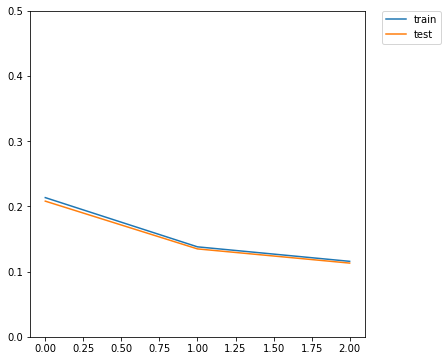

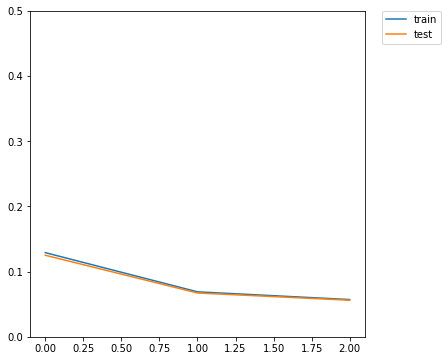

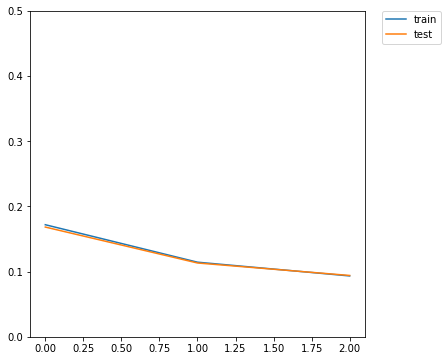

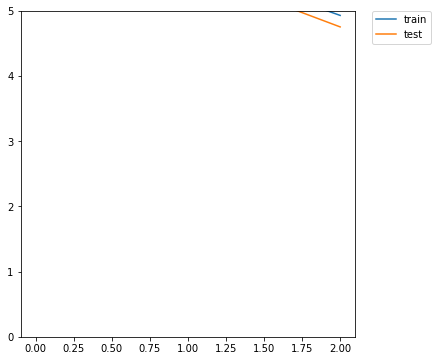

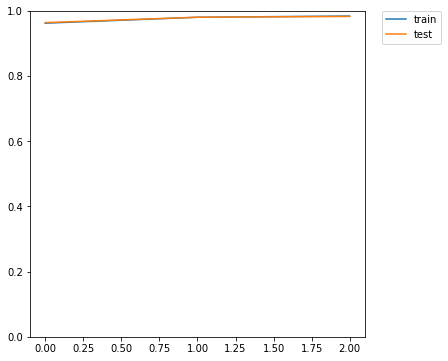

In [7]:
plot_graph(losses, 0.5, filename="loss")
plot_graph(cel_losses, 0.5, filename="cross entropy loss")
plot_graph(center_losses, 0.5, filename="center loss")
plot_graph(discriminant_losses, 5.0, filename="discriminant loss")
plot_graph(accuracies, 1, filename="accuracy")

In [8]:
info = {}
info["DATASET"] = DATASET
info["Learnign_rate"] = LEARNING_RATE
info["Weight_decay"] = WEIGHT_DECAY
info["EPOCH"] = EPOCH
info["STEPS"] = STEPS
info["GAMMA"] = GAMMA
info["Model"] = model
info["Criterion"] = criterion
info["Optimizer"] = optimizer
info["train_loss"] = losses["train"][-1]
info["test_loss"] = losses["test"][-1]
info["train_cel_loss"] = cel_losses["train"][-1]
info["test_cel_loss"] = cel_losses["test"][-1]
info["train_center_loss"] = center_losses["train"][-1]
info["test_center_loss"] = center_losses["test"][-1]
info["train_discriminant_loss"] = discriminant_losses["train"][-1]
info["test_discriminant_loss"] = discriminant_losses["test"][-1]
info["train_acc"] = accuracies["train"][-1]
info["test_acc"] = accuracies["test"][-1]
info["DIM"] = DIM
info["center_ALPHA"] = center_ALPHA
info["center_LAMBDA"] = center_LAMBDA
info["discriminant_ALPHA"] = discriminant_ALPHA
info["discriminant_LAMBDA"] = discriminant_LAMBDA

In [9]:
save_info(info, DATASET+"_info")

In [10]:
torch.save(model.cpu().state_dict(), 'model_param.pth')
torch.save(model.cpu(), 'model.pth')

In [11]:
train_embedding = cfcd.getLatents(trainloader, based_labels, device=device)
test_embedding = cfcd.getLatents(testloader, based_labels, device=device)
train_outputs = cfcd.getOutputs(trainloader, based_labels, device=device)
test_outputs = cfcd.getOutputs(testloader, based_labels, device=device)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.60it/s]


In [12]:
train_embedding, test_embedding, pca = dict_to_PCA(
    train_embedding,
    test_embedding,
    dim=2,
)

11it [00:00, ?it/s]
11it [00:00, ?it/s]


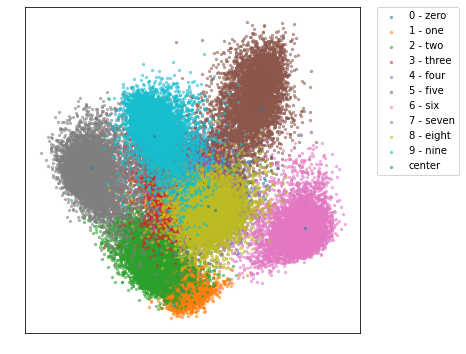

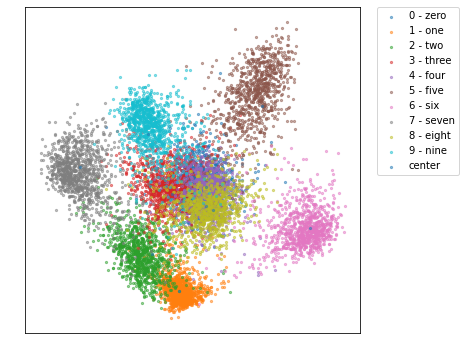

In [13]:
plot_scatter(train_embedding, filename="train_embeddings")
plot_scatter(test_embedding, filename="test_embeddings")

In [14]:
train_outputs = dict_to_oneVSothers(train_outputs)
test_outputs = dict_to_oneVSothers(test_outputs)

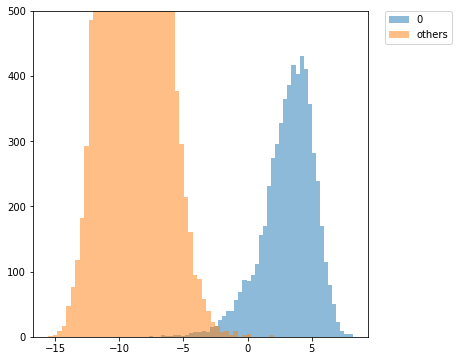

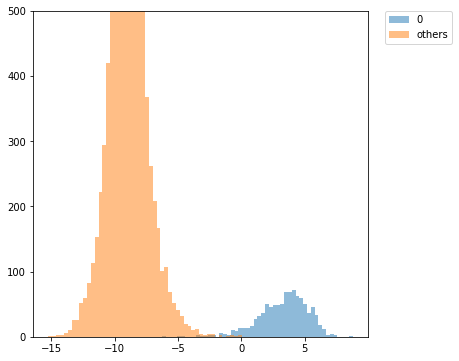

In [15]:
plot_histogram(train_outputs, filename="train_histogram")
plot_histogram(test_outputs, filename="test_histogram")